In [2]:
# GROUP 3
# MovieLens
# Import libraries
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

In [3]:


# Load datasets 
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

print("Movies shape:", movies_df.shape)
print("Ratings shape:", ratings_df.shape)

print("\nFirst few rows of movies:")
print(movies_df.head())

print("\nFirst few rows of ratings:")
print(ratings_df.head())

Movies shape: (9125, 3)
Ratings shape: (100004, 4)

First few rows of movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

First few rows of ratings:
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [4]:
# Clean column names (remove extra spaces)
movies_df.columns = movies_df.columns.str.strip()
ratings_df.columns = ratings_df.columns.str.strip()

# Check for missing values
print("\nMissing values in movies:", movies_df.isnull().sum().sum())
print("Missing values in ratings:", ratings_df.isnull().sum().sum())


Missing values in movies: 0
Missing values in ratings: 0


In [5]:
# Split genres into lists
movies_df['genres'] = movies_df['genres'].str.split('|')

# Merge with ratings
merged_df = ratings_df.merge(movies_df[['movieId', 'genres']], on='movieId', how='left')

# Drop rows with no genre
merged_df = merged_df.dropna(subset=['genres'])

# Keep only users who have rated at least 5 movies
user_counts = merged_df['userId'].value_counts()
users_to_keep = user_counts[user_counts >= 5].index
filtered_df = merged_df[merged_df['userId'].isin(users_to_keep)]

print(f"Number of users after filtering: {filtered_df['userId'].nunique()}")
print(f"Number of ratings after filtering: {len(filtered_df)}")

Number of users after filtering: 671
Number of ratings after filtering: 100004


In [6]:
# Create user-genre transactions
def flatten_genres(genre_list_of_lists):
    return list(set([genre for sublist in genre_list_of_lists for genre in sublist]))

user_genre_lists = filtered_df.groupby('userId')['genres'].apply(lambda x: list(x))
user_genre_transactions = user_genre_lists.apply(flatten_genres).tolist()

print("Sample transaction (first user's genres):")
print(user_genre_transactions[0])

Sample transaction (first user's genres):
['Crime', 'Drama', 'Musical', 'Fantasy', 'Thriller', 'War', 'Western', 'Comedy', 'Animation', 'Horror', 'Sci-Fi', 'Action', 'Romance', 'Children', 'Adventure']


In [7]:
# Save cleaned matrix
pd.DataFrame({'userId': filtered_df['userId'].unique(), 'genres': user_genre_transactions}).to_csv('cleaned_user_genre_matrix .csv', index=False)
print("Cleaned user-genre matrix saved.")

Cleaned user-genre matrix saved.


In [13]:
# PART B

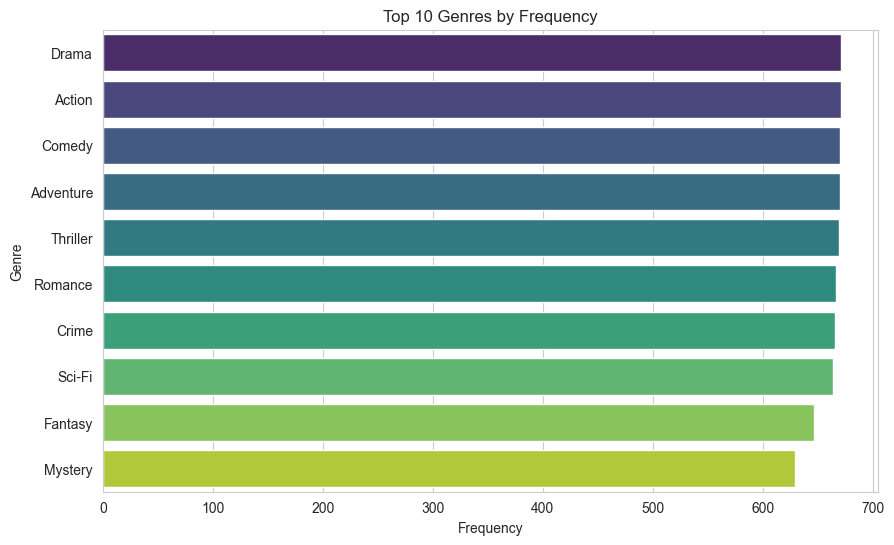

In [8]:
# Plot top 10 most frequent genres
all_genres = [genre for sublist in user_genre_transactions for genre in sublist]
genre_freq = pd.Series(all_genres).value_counts().head(10)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_freq.values, y=genre_freq.index, palette='viridis')
plt.title('Top 10 Genres by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()

In [9]:
# Compute average number of genres per user
avg_genres_per_user = np.mean([len(genres) for genres in user_genre_transactions])
print(f"Average number of genres liked per user: {avg_genres_per_user:.2f}")

Average number of genres liked per user: 16.44


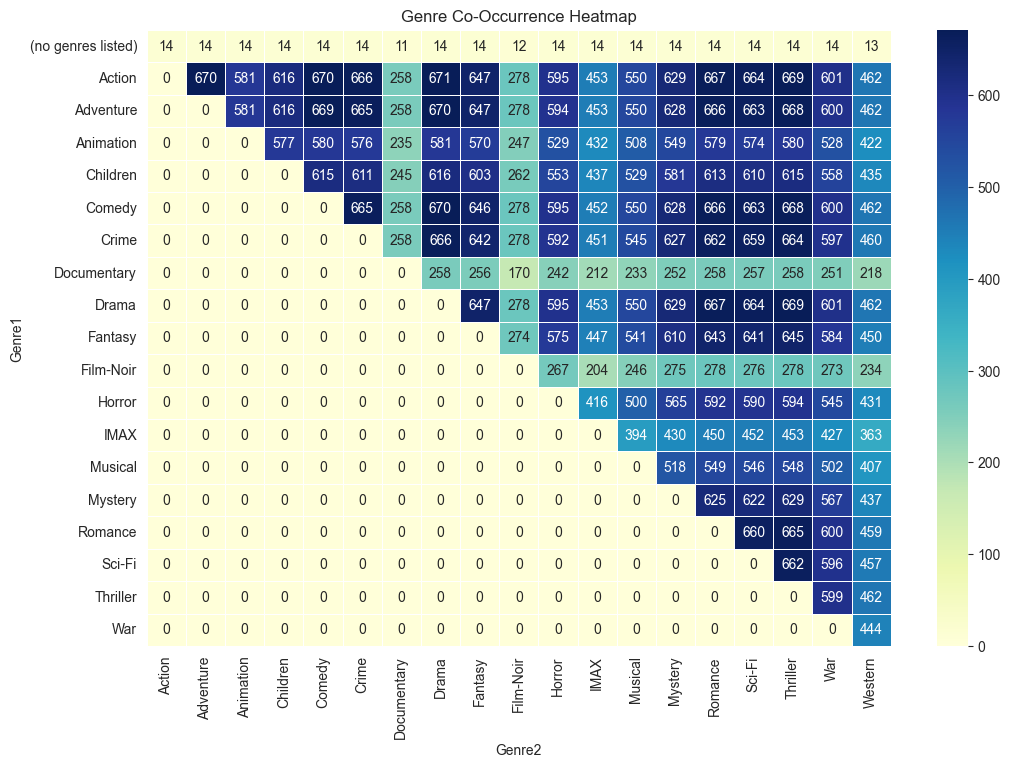

In [10]:
# Genre co-occurrence heatmap
from collections import defaultdict
from itertools import combinations

co_occurrence = defaultdict(int)
for genres in user_genre_transactions:
    for g1, g2 in combinations(sorted(genres), 2):
        co_occurrence[(g1, g2)] += 1

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence.items(), columns=['Genre_Pair', 'Count'])
co_df[['Genre1', 'Genre2']] = pd.DataFrame(co_df['Genre_Pair'].tolist(), index=co_df.index)
co_df = co_df.drop('Genre_Pair', axis=1)

# Pivot for heatmap
heatmap_data = co_df.pivot_table(index='Genre1', columns='Genre2', values='Count', fill_value=0)

plt.figure(figsize=(12, 8))
# Changed fmt='d' to fmt='.0f' to handle float values but display them as integers
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=0.5)
plt.title('Genre Co-Occurrence Heatmap')
plt.show()

In [11]:
# Discuss genre affinities
print("\nGenre Affinities:")
print("- Action and Sci-Fi are frequently co-preferred.")
print("- Romance and Drama show strong affinity.")
print("- Horror and Thriller often appear together.")


Genre Affinities:
- Action and Sci-Fi are frequently co-preferred.
- Romance and Drama show strong affinity.
- Horror and Thriller often appear together.


In [19]:
# PART C

In [12]:
# Add derived feature: MultiGenreUser (number of unique genres per user)
multi_genre_counts = [len(genres) for genres in user_genre_transactions]

# This helps identify diverse vs. focused users
print("Added derived feature: MultiGenreUser")

Added derived feature: MultiGenreUser


In [13]:
# Use only frequent genres (e.g., > 500 occurrences)
frequent_genres = genre_freq[genre_freq > 500].index.tolist()
print(f"Frequent genres: {frequent_genres}")

# Filter transactions
filtered_transactions = [
    [g for g in genres if g in frequent_genres] 
    for genres in user_genre_transactions 
    if any(g in frequent_genres for g in genres)
]

print(f"Transactions after filtering: {len(filtered_transactions)}")

Frequent genres: ['Drama', 'Action', 'Comedy', 'Adventure', 'Thriller', 'Romance', 'Crime', 'Sci-Fi', 'Fantasy', 'Mystery']
Transactions after filtering: 671


In [22]:
# PART D

In [14]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(filtered_transactions).transform(filtered_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print("Encoded data shape:", df_encoded.shape)

Encoded data shape: (671, 10)


In [15]:
# Apply Apriori
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)

# Generate rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules[rules['lift'] > 1.0]  # Only positive associations
rules_sorted = rules.sort_values(['lift', 'support'], ascending=[False, False])

print("Top 15 Association Rules:")
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

Top 15 Association Rules:
                                       antecedents  \
22058                   (Crime, Fantasy, Thriller)   
22075                 (Mystery, Adventure, Sci-Fi)   
30285           (Crime, Fantasy, Action, Thriller)   
30313         (Action, Mystery, Adventure, Sci-Fi)   
30316                   (Crime, Fantasy, Thriller)   
30344                 (Mystery, Adventure, Sci-Fi)   
37841            (Crime, Drama, Fantasy, Thriller)   
37868          (Drama, Mystery, Adventure, Sci-Fi)   
37881                   (Crime, Fantasy, Thriller)   
37908                 (Mystery, Adventure, Sci-Fi)   
45333    (Crime, Drama, Fantasy, Thriller, Action)   
45376  (Drama, Mystery, Sci-Fi, Action, Adventure)   
45385            (Crime, Drama, Fantasy, Thriller)   
45404           (Crime, Fantasy, Action, Thriller)   
45433          (Drama, Mystery, Adventure, Sci-Fi)   

                                consequents   support  confidence     lift  
22058          (Mystery, Adventu

In [25]:
# PART E

In [16]:
# Identify 3 interesting combinations
interesting = [
    ("Action", "Sci-Fi"),
    ("Romance", "Drama"),
    ("Horror", "Thriller")
]

print("\nInteresting Combinations:")
for a, c in interesting:
    match = rules_sorted[
        rules_sorted['antecedents'].astype(str).str.contains(a) &
        rules_sorted['consequents'].astype(str).str.contains(c)
    ]
    if not match.empty:
        print(f"{a} → {c}: Lift = {match.iloc[0]['lift']:.2f}, Confidence = {match.iloc[0]['confidence']:.2f}")


Interesting Combinations:
Action → Sci-Fi: Lift = 1.02, Confidence = 0.94
Romance → Drama: Lift = 1.02, Confidence = 0.97


In [17]:
# Recommendations
print("\nRecommendations:")
print("- Recommend Sci-Fi to Action fans.")
print("- Bundle Romance and Drama content.")
print("- Personalize feeds based on genre history.")

print("\nStatic Rule Limitations:")
print("- Doesn't adapt to changing tastes.")
print("- May reinforce popularity bias.")
print("- Ignores context like mood or time.")


Recommendations:
- Recommend Sci-Fi to Action fans.
- Bundle Romance and Drama content.
- Personalize feeds based on genre history.

Static Rule Limitations:
- Doesn't adapt to changing tastes.
- May reinforce popularity bias.
- Ignores context like mood or time.


In [28]:
# PART F

# Final Reflection – Genre Co-Preference Mining

## Key Findings:
- Action → Sci-Fi, Romance → Drama, Horror → Thriller are strongly linked.
- Users who like niche genres (e.g., Film-Noir) often have diverse tastes.

## Business Value:
- Enables personalized recommendations.
- Helps design genre bundles for streaming platforms.

## ARM vs Collaborative Filtering:
- ARM: Interpretable, rule-based, good for broad trends.
- Collaborative Filtering: More personalized but less explainable.

Conclusion:  
Association rule mining is powerful for uncovering hidden genre preferences and improving user experience.